# "Laplacian Matrix Learning for Smooth Graph Signal Representation" [Dong et al., 2015]

In [1]:
from scipy import spatial
from sklearn import metrics
import pygsp
import utils
import learn_graph as lg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxopt
import copy
%matplotlib inline

## Generate ground truth graph

In [2]:
N = 256 # Number of nodes
Ne = (N * (N - 1)) // 2 # number of edges

D = 4 # dimension of signal

G = pygsp.graphs.Sensor(N, seed=1)

W_gt = G.W.toarray()

pos = G.coords

G_nx = nx.from_numpy_matrix(W_gt)

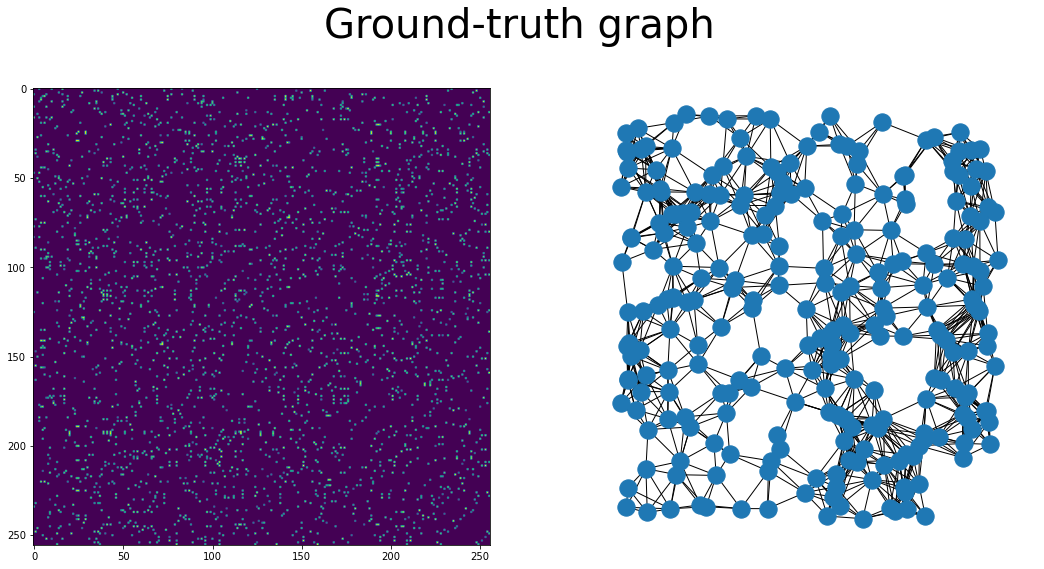

In [3]:
plt.figure(figsize=(18, 9))
plt.suptitle('Ground-truth graph', fontsize=40)

plt.subplot(1,2,1)
plt.imshow(W_gt)

plt.subplot(1,2,2)
nx.draw(G_nx, pos=pos)

## Generate samples

In [4]:
def s1(x, y): 
    return np.sin((2 - x - y)**2) 
def s2(x, y): 
    return np.cos((x + y)**2)
def s3(x, y): 
    return (x - 0.5)**2 + (y - 0.5)**3 + x - y 
def s4(x, y): 
    return np.sin(3 * ( (x - 0.5)**2 + (y - 0.5)**2 ) )

X = 5 * np.array((s1(G.coords[:,0], G.coords[:,1]), 
                  s2(G.coords[:,0], G.coords[:,1]), 
                  s3(G.coords[:,0], G.coords[:,1]), 
                  s4(G.coords[:,0], G.coords[:,1]))).T


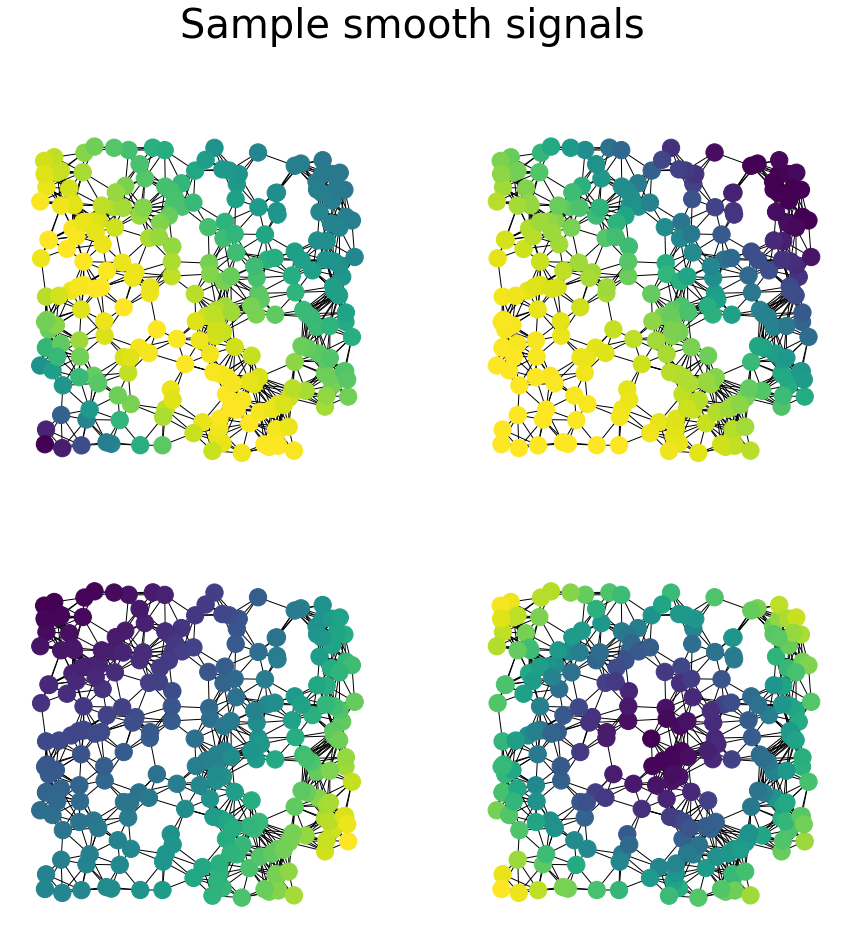

In [5]:
plt.figure(figsize=(15, 15))
plt.suptitle('Sample smooth signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_nx, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_nx, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_nx, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_nx, pos=pos, node_color=X[:,3])

## Solve the optimization problem

In [6]:
def solve(X, N, B=100, iter_random=100, edge_count_threshold=1, is_guided=True, k=1, iter_guided=100, eps=1e-4):
    
    # for the first few iterations, run randomized subgraph learning
    # (specifically if you want at least t times, do it 2t (log N + c) * N/B times)
    # running while loop will probably be much faster though
    
    # now for the guided learning part, do the following while the graph is not visited
    
    # k nearest neighbours
    
    # function to learn a subgraph from node indices:
    def solve_subgraph(X, node_indices, W, count):
        X_chosen = X[np.ix_(node_indices)]
        W_subgraph = lg.l2_degree_reg(X_chosen, dist_type='sqeuclidean', alpha=1, retall=False)
        W_subgraph[W_subgraph < 0] = 0
        W[np.ix_(node_indices, node_indices)] += W_subgraph
        count[np.ix_(node_indices, node_indices)] += 1
    
    count = np.zeros((N, N), dtype=np.int32)
    W = np.zeros((N, N))
    iteration = 0
    while np.min(count) < edge_count_threshold and iteration < iter_random:
        iteration += 1
        perm = np.random.permutation(N)
        for i in range((N + B - 1) // B):
            left = i
            right = min(i + B, N)
            node_indices = perm[left : right]
            solve_subgraph(X, node_indices, W, count)
    W /= np.maximum(1, count)
    if not is_guided:
        W[W < eps] = 0
        return W
    
    count = np.ones((N, N), dtype=np.int32)
    unvisited = np.array([1 for i in range(N)])
    for iteration in range(iter_guided * N // B):
        # pick most important vertex
        v = np.argmax(np.sum(W, axis=1) * unvisited)
        if not unvisited[v]:
            unvisited = np.array([1 for i in range(N)])
            v = np.argmax(np.sum(W, axis=1))
        node_count = 1
        queue = [v]
        queue_start = 0
        unvisited[v] = 0
        # keep choosing top k neighbours in bfs while stuff is unvisited
        while node_count < B and queue_start < len(queue):
            u = queue[queue_start]
            queue_start += 1
            adjacent = np.argsort(W[u])
            count_neighbours = 0
            for cur_node in adjacent:
                if count_neighbours >= k: break
                if node_count + count_neighbours >= B: break
                if unvisited[cur_node]:
                    unvisited[cur_node] = 0
                    queue.append(cur_node)
                    count_neighbours += 1
            node_count += count_neighbours
        # print(queue)
        W *= count
        solve_subgraph(X, np.array(queue), W, count)
        W /= np.maximum(1, count)
    W[W < eps] = 0
    return W

In [7]:
total_iter = 50
C = 20
B = 64
eps = 1e-3
do_guided = True
if do_guided:
    W_batch = solve(X, N, B=B, iter_random=total_iter // 2, edge_count_threshold=2, is_guided=True, k=C, iter_guided=total_iter // 2, eps=eps)
else:
    W_batch = solve(X, N, B=B, iter_random=total_iter, edge_count_threshold=2, is_guided=False, k=C, iter_guided=0, eps=eps)

In [8]:
W = lg.l2_degree_reg(X, dist_type='sqeuclidean', alpha=1, retall=False)
W[W < eps] = 0

## Recover learned graph

In [9]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < 0.1 * np.max(W_gt)] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

W_batch_thresh = np.max(W_gt) * W_batch / np.max(W_batch)
W_batch_thresh[W_batch_thresh < 0.1 * np.max(W_gt)] = 0
G_batch_learned = nx.from_numpy_matrix(W_batch_thresh)

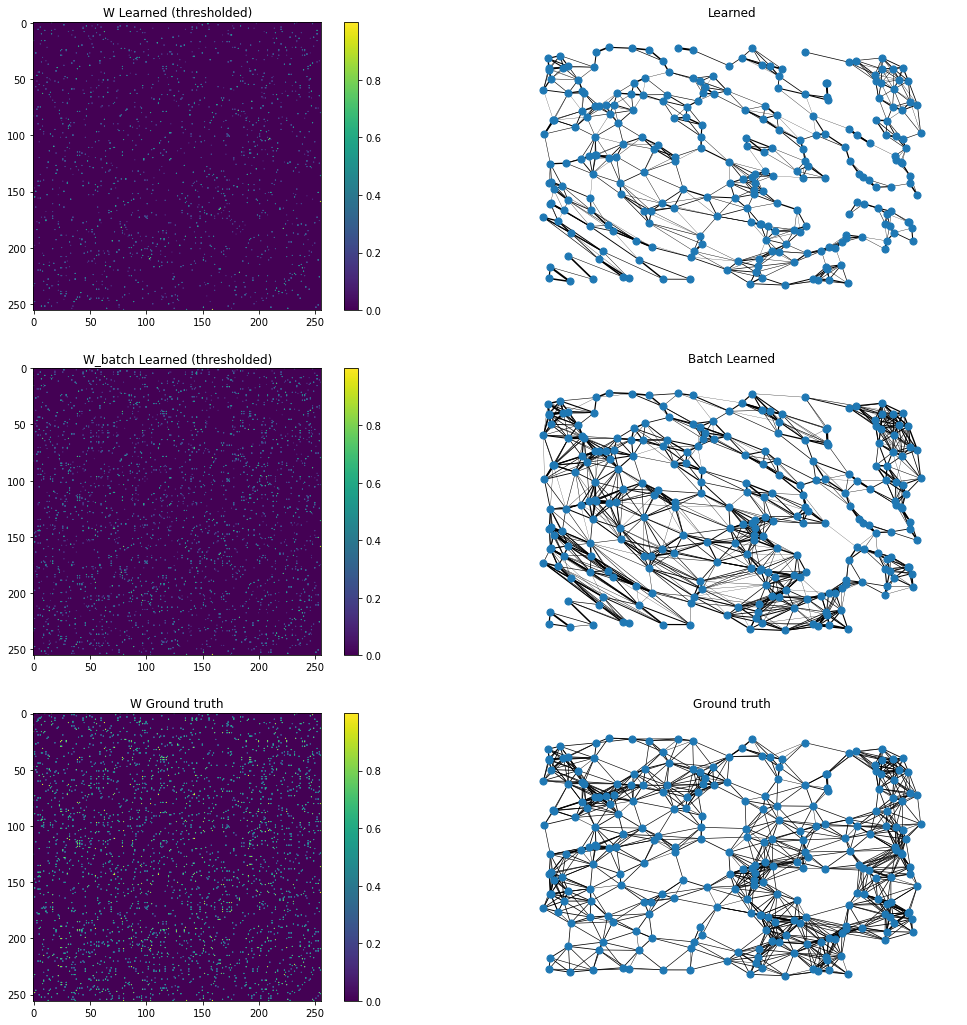

In [10]:
NODE_SIZE = 50
FACTOR = 2

plt.figure(figsize=(18, 18))
plt.subplot(3,2,1)
plt.imshow(W_thresh)
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(3,2,2)
edge_wts = [FACTOR * W_thresh[edge[0], edge[1]] for edge in G_learned.edges()]
nx.draw(G_learned, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,3)
plt.imshow(W_batch_thresh)
plt.colorbar()
plt.title('W_batch Learned (thresholded)')

plt.subplot(3,2,4)
edge_wts = [FACTOR * W_batch_thresh[edge[0], edge[1]] for edge in G_batch_learned.edges()]
nx.draw(G_batch_learned, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Batch Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,5)
plt.imshow(W_gt)
plt.colorbar()
plt.title('W Ground truth')

FACTOR /= 2

plt.subplot(3,2,6)
edge_wts = [FACTOR * W_gt[edge[0], edge[1]] for edge in G_nx.edges()]
nx.draw(G_nx, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Ground truth')

plt.show()

In [11]:
f_score = metrics.f1_score(
                            (spatial.distance.squareform(copy.deepcopy(W_gt)) > 0),
                            (spatial.distance.squareform(copy.deepcopy(W)) > 0)
)

f_score_imputed = metrics.f1_score(
                            (spatial.distance.squareform(copy.deepcopy(W_gt)) > 0), 
                            (spatial.distance.squareform(copy.deepcopy(W_batch)) > 0)
)

print("F-score (complete) = {:.2f}".format(f_score))
print("F-score (batch) = {:.2f}".format(f_score_imputed))

F-score (complete) = 0.70
F-score (batch) = 0.74


## Compare spectra of the Laplacian matrices

In [12]:
L = utils.create_laplacian(W, lap_type='normalized', 
                           sparse_flag=False)
L_batch = utils.create_laplacian(W_batch, lap_type='normalized', 
                           sparse_flag=False)
L_gt = utils.create_laplacian(W_gt, lap_type='normalized', 
                           sparse_flag=False)

e, _ = np.linalg.eigh(L)
e = np.sort(e)

e_gt, _ = np.linalg.eigh(L_gt)
e_gt = np.sort(e_gt)

e_batch, _ = np.linalg.eigh(L_batch)
e_batch = np.sort(e_batch)

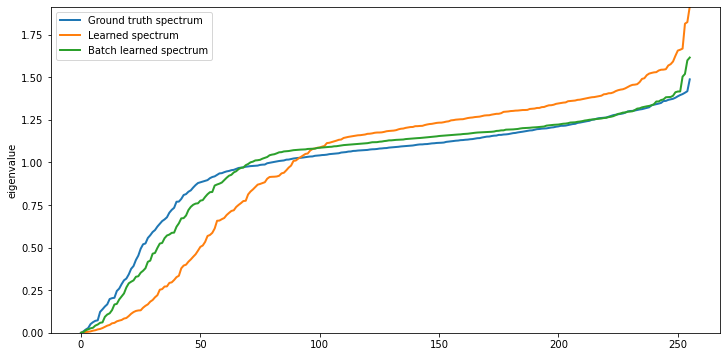

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(e_gt, linewidth=2)
plt.plot(e, linewidth=2)
plt.plot(e_batch, linewidth=2)
plt.ylabel('eigenvalue')
plt.ylim([0,max(np.max(e_gt), np.max(e), np.max(e_batch))])
plt.legend(['Ground truth spectrum', 'Learned spectrum', 'Batch learned spectrum'], loc='best')

plt.show()

In [14]:
np.sum((e_gt - e_batch) ** 2)

0.8317726638031655

In [15]:
np.sum((e_gt - e) ** 2)

9.804609280173176